visualisation sur la carte

In [ ]:
import pandas as pd
import folium

# --- Chemin vers ton fichier CSV ---
chemin_csv = r"C:\Users\Durant.Nguefack\Downloads\yellow_tripdata\yellow_tripdata_2015-01.csv"  # <-- adapte selon ton fichier

# --- Lire le fichier ---
df = pd.read_csv(chemin_csv)

# --- Nettoyage : enlever les lignes sans coordonnées valides ---
df = df.dropna(subset=['pickup_latitude', 'pickup_longitude'])

# --- Limiter à 10 000 lignes pour éviter de surcharger la carte ---
df_sample = df.sample(n=10000, random_state=42)

# --- Créer la carte centrée sur New York ---
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# --- Ajouter les points de départ à la carte ---
for _, row in df_sample.iterrows():
    folium.CircleMarker(
        location=[row['pickup_latitude'], row['pickup_longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.4
    ).add_to(m)

# --- Sauvegarder la carte ---
m.save("map.html")
print("Carte générée : 'map.html'")



Carte générée : 'pickup_map_one_file.html'


Diviser l’espace géographique (New York) en zones géométriques régulières (ex. : hexagones) et compter combien de trajets (ou points de départ) tombent dans chaque zone.

In [ ]:
import pandas as pd
import h3
from shapely.geometry import Polygon
import geopandas as gpd
import folium


# Conversion coordonnées vers H3
df_sample['hex_id'] = df_sample.apply(
    lambda row: h3.latlng_to_cell(row['pickup_latitude'], row['pickup_longitude'], resolution), axis=1
)

# Comptage par hexagone
df_counts = df_sample.groupby('hex_id').size().reset_index(name='count')

# Fonction corrigée pour v4.x.x : (sans geo_json=True)
def hex_to_polygon(h):
    boundary = h3.cell_to_boundary(h)  # <-- sans geo_json !
    return Polygon([(lng, lat) for lat, lng in boundary])  # inversion nécessaire (lng, lat)

# Création des polygones géométriques
df_counts['geometry'] = df_counts['hex_id'].apply(hex_to_polygon)

# GeoDataFrame
gdf = gpd.GeoDataFrame(df_counts, geometry='geometry', crs="EPSG:4326")

# Carte interactive Folium
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Ajouter les hexagones colorés
for _, row in gdf.iterrows():
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda x, count=row['count']: {
            'fillColor': 'darkred' if count > 100 else 'red' if count > 50 else 'orange' if count > 20 else 'yellow',
            'color': 'black',
            'weight': 0.4,
            'fillOpacity': 0.7,
        },
        tooltip=f"{row['count']} trajets"
    ).add_to(m)

# Sauvegarder
m.save("map_hexagonale.html")
print("Carte hexagonale créée avec succès : map.html")


Carte hexagonale créée avec succès : hex_map.html


 Modéliser les données de mobilité avec un graphe spatial 

In [ ]:
import pandas as pd
import h3
import networkx as nx
import matplotlib.pyplot as plt


# Conversion coordonnées pickup/dropoff → hex_id H3
df_sample['pickup_hex'] = df_sample.apply(
    lambda row: h3.latlng_to_cell(row['pickup_latitude'], row['pickup_longitude'], resolution), axis=1
)
df_sample['dropoff_hex'] = df_sample.apply(
    lambda row: h3.latlng_to_cell(row['dropoff_latitude'], row['dropoff_longitude'], resolution), axis=1
)

# Créer un graphe orienté (pickup → dropoff)
G = nx.DiGraph()

# Ajouter des arêtes et compter les trajets entre hexagones
for _, row in df_sample.iterrows():
    pickup, dropoff = row['pickup_hex'], row['dropoff_hex']
    if G.has_edge(pickup, dropoff):
        G[pickup][dropoff]['weight'] += 1
    else:
        G.add_edge(pickup, dropoff, weight=1)

print(f" Graphe construit : {G.number_of_nodes()} hexagones, {G.number_of_edges()} connexions")


✅ Graphe construit : 393 hexagones, 3326 connexions


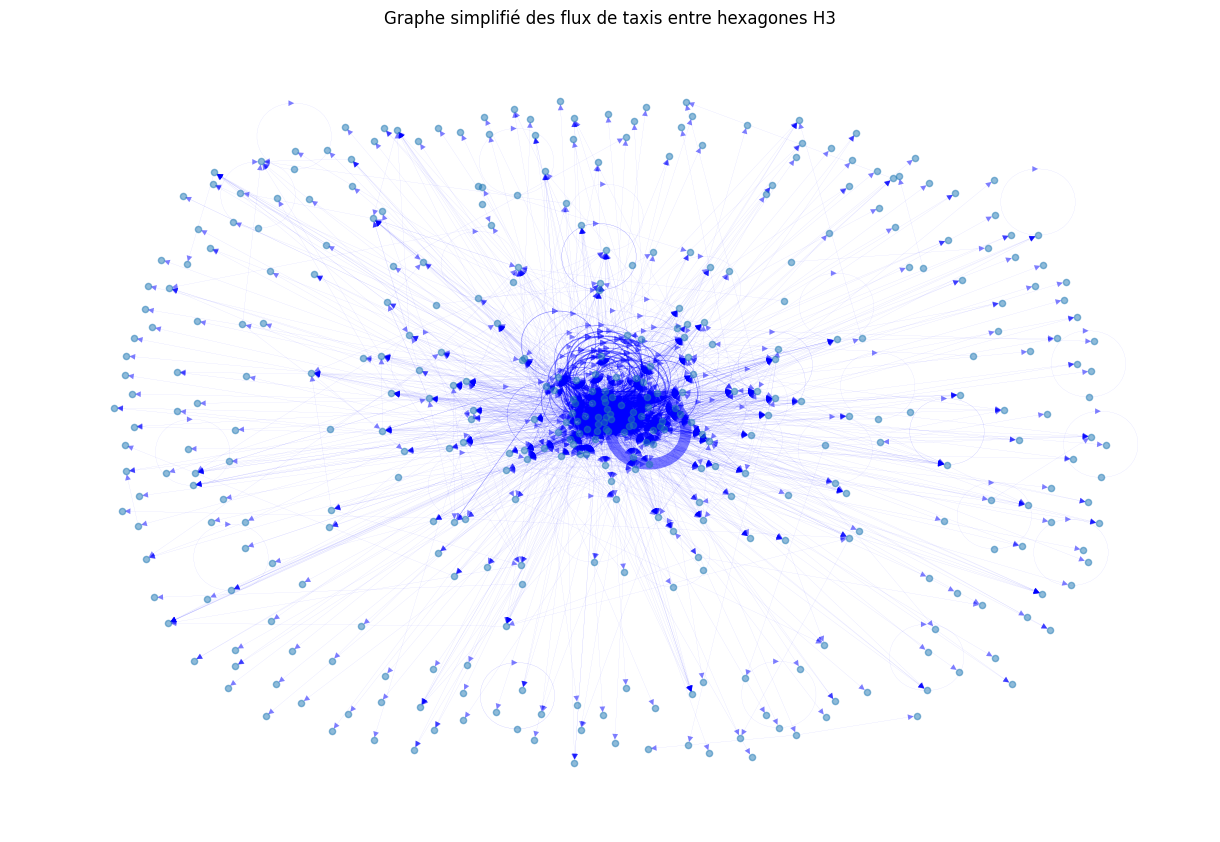

In [ ]:
# Visualisation simple du graphe 
plt.figure(figsize=(12, 8))

# positions aléatoires pour simplifier 
pos = nx.spring_layout(G, k=0.15, iterations=20)

# Dessiner le graphe avec poids comme largeur d'arête
nx.draw(G, pos, node_size=20, with_labels=False, edge_color='blue', alpha=0.5,
        width=[G[u][v]['weight']*0.05 for u,v in G.edges])

plt.title("Graphe simplifié des flux de taxis entre hexagones H3")
plt.show()
